In [1]:
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # data visualization
import matplotlib.dates as mdates
import warnings
from dateutil.relativedelta import relativedelta
from module import myFunctions
import seaborn as sns
import os.path
import statsmodels.api as sm
import importlib
from pandas.plotting import autocorrelation_plot
import plotly.offline as py
import plotly.graph_objs as go

def reloadMyModule():
    importlib.reload(myFunctions)

warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

showGraphs = False

%matplotlib inline


2022-06-04 15:09:45.344410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 15:09:45.344440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Any results you write to the current directory are saved as output.

path_to_file = "./data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"

if not (os.path.exists(path_to_file)):
    raise Exception("File not found. Please download the file from the link below and place it in the data folder https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data")

coinbase = pd.read_csv(path_to_file)

coinbase.describe()
coinbase.tail()
coinbase.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


Filtrar intervalo de dados

In [3]:
reloadMyModule()

filtered = myFunctions.filterByInterval(coinbase, relativedelta(months=12))

historical_per_day = myFunctions.groupByDay(filtered)
historical_per_hour = myFunctions.groupByHour(filtered)
historical_per_minute = myFunctions.groupByMinute(filtered)
if myFunctions.hasMissingData(filtered['Timestamp'].values):
    raise Exception("Missing data in the dataframe")

print("O intervalo entre datas é de {} até {}, somando um total de {} registros.".format(
    myFunctions.getFirstTimestamp(filtered), myFunctions.getLastTimestamp(filtered), filtered.shape[0]))


O intervalo entre datas é de 30/03/2020 21:01:00 até 30/03/2021 21:00:00, somando um total de 525600 registros.


# Análise e Exploração dos Dados 

## Prepara os dados históricos agrupandos por hora

In [4]:
reloadMyModule()

if showGraphs:
    kw = dict(annot_yaxis=10000, annot_xaxis=-1000, annot_xaxis_pos=-6000, annot_yaxis_pos=-
              8000, angle="angle,angleA=0,angleB=90", angle_pos="angle,angleA=0,angleB=-90", showAnnotate=True)
    myFunctions.figureCloses(filtered, 'Close', **kw)


## Gráfico Volatility

In [5]:
def volatiltyGraph(data):
    returns = data.pct_change().dropna(axis=0)
    plt.figure(figsize=(14, 6))
    plt.title('BTC - Volatilidade')
    plt.grid()
    returns['Close'].plot(label='Close', color='blue',
                          linewidth=2, alpha=0.8, legend=True)
    plt.autoscale(tight=True)
    plt.axhline(y=0, color='black')
    plt.axhline(y=0.05, color='red')
    plt.axhline(y=-0.05, color='red')
    plt.axhline(y=0.1, color='red')
    plt.axhline(y=-0.1, color='red')
    plt.xlabel(None)

    plt.show()


if showGraphs:
    volatiltyGraph(historical_per_day)


## Heatmap

In [6]:
def heatmapGraph(data):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=True,
                linewidths=.9, fmt='.1f', ax=ax)
    plt.show()


if showGraphs:
    heatmapGraph(historical_per_day)


## Dia da semana com valor mais baixo

In [7]:
def lowestDuringWeek(data):
    data.Timestamp = pd.to_datetime(data.Timestamp, unit='s')
    data = data.dropna()

    week = {0: 'Seg', 1: 'Ter', 2: 'Qua',
            3: 'Qui', 4: 'Sex', 5: 'Sab', 6: 'Dom'}
    data['Dia da Semana'] = data['Timestamp'].dt.dayofweek.map(week)

    # count min value for each week day
    idx = data.groupby([pd.Grouper(key='Timestamp', freq='W-MON')]
                       )['Close'].transform(min) == data['Close']

    # data is still in minutes, so I calculate it for days.
    lows_count = data[idx].groupby(
        [pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
    lows_count = lows_count.dropna()

    sns.set(rc={'figure.figsize': (14, 6)})
    ax = sns.countplot(x='Dia da Semana', data=lows_count, order=[
                       'Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab', 'Dom'])
    ax.set(ylabel='Quantidade de vezes com valor mais baixo')


if showGraphs:
    lowestDuringWeek(historical_per_minute)


# PREPARAÇÃO DOS DADOS PARA OS MODELOS DE APRENDIZADO DE MÁQUINA

In [8]:
reloadMyModule()
# https://www.kaggle.com/code/jeongbinpark/lstm-can-we-predict-the-bitcoin-price


def removeUnusedColumns(df):
    df.drop(['Open', 'Volume_(BTC)', 'Volume_(Currency)',
            'Weighted_Price', 'High', 'Low'], axis=1, inplace=True)
    return df


def groupByTimer(df, interval):
    print("Grouping data by {}".format(interval))
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
    df = df.set_index('Timestamp')
    df = df.resample(interval).mean()
    df = df.dropna()
    return df


def normalize(values):
    scaler = MinMaxScaler()
    return scaler.fit_transform(np.array(values).reshape(-1, 1))


df = removeUnusedColumns(filtered.copy())
df = groupByTimer(df, '1H')
df['Close'] = normalize(df['Close'])
df.head()


Grouping data by 1H


,Close
Timestamp,
2020-03-31 00:00:00,0.004642
2020-03-31 01:00:00,0.005183
2020-03-31 02:00:00,0.005290
2020-03-31 03:00:00,0.004583
2020-03-31 04:00:00,0.004066


In [9]:
reloadMyModule()
X_l = []
y_l = []
N = len(df)
D = 50
for i in range(N-D-1):
    X_l.append(df.iloc[i:i+D])
    y_l.append(df.iloc[i+D])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)


(8706, 50, 1) (8706, 1)


In [10]:
reloadMyModule()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100)


In [16]:
# m_x = Input(shape = X_train.shape[1:])
# m_h = LSTM(10)(m_x)
# m_y = Dense(1)(m_h)
# m = Model(m_x,m_y)
# m.compile('adam','mse')
# m.summary()

# Initialising the LSTM
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50)                2

In [18]:
history = regressor.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test),verbose=2)

Epoch 1/250
218/218 - 23s - loss: 8.1836e-04 - val_loss: 2.7416e-04 - 23s/epoch - 104ms/step
Epoch 2/250
218/218 - 23s - loss: 8.0585e-04 - val_loss: 2.4238e-04 - 23s/epoch - 107ms/step
Epoch 3/250
218/218 - 23s - loss: 7.9766e-04 - val_loss: 1.3157e-04 - 23s/epoch - 103ms/step
Epoch 4/250
218/218 - 22s - loss: 7.3137e-04 - val_loss: 1.5972e-04 - 22s/epoch - 103ms/step
Epoch 5/250
218/218 - 23s - loss: 8.4092e-04 - val_loss: 1.5245e-04 - 23s/epoch - 103ms/step
Epoch 6/250
218/218 - 23s - loss: 7.4370e-04 - val_loss: 0.0011 - 23s/epoch - 104ms/step
Epoch 7/250
218/218 - 23s - loss: 8.3040e-04 - val_loss: 3.5721e-04 - 23s/epoch - 104ms/step
Epoch 8/250
218/218 - 23s - loss: 7.2370e-04 - val_loss: 1.5993e-04 - 23s/epoch - 103ms/step
Epoch 9/250
218/218 - 23s - loss: 7.0880e-04 - val_loss: 1.1667e-04 - 23s/epoch - 104ms/step
Epoch 10/250
218/218 - 23s - loss: 7.5455e-04 - val_loss: 6.2609e-04 - 23s/epoch - 104ms/step
Epoch 11/250
218/218 - 22s - loss: 7.8700e-04 - val_loss: 3.3859e-04 - 22

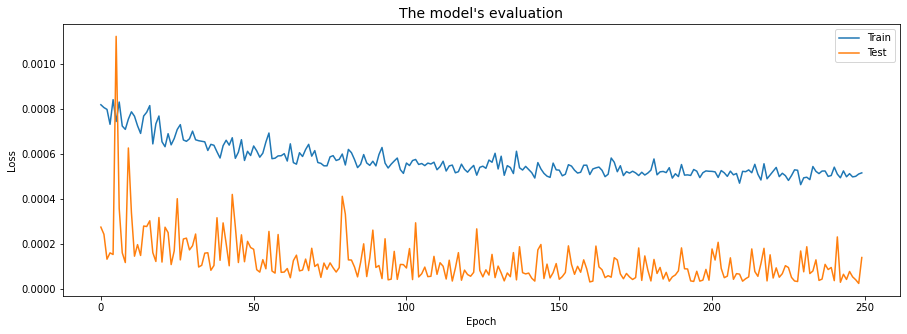

In [19]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# We will predict 300 datas


In [14]:
pred = []
pr = regressor.predict(np.array(df[-50:]))
pred.append(pr[0])

for i in range(1,50):
    arr = np.concatenate((np.array(df[-50+i:]), pred[:]), axis=0)
    pr = regressor.predict(arr)
    pred.append(pr[0])

for i in range(0,250):
    pr = regressor.predict(np.concatenate(pred[i:],axis=0).reshape(-1,1))
    pred.append(pr[0])

2/2 [==============================] - 0s 3ms/step


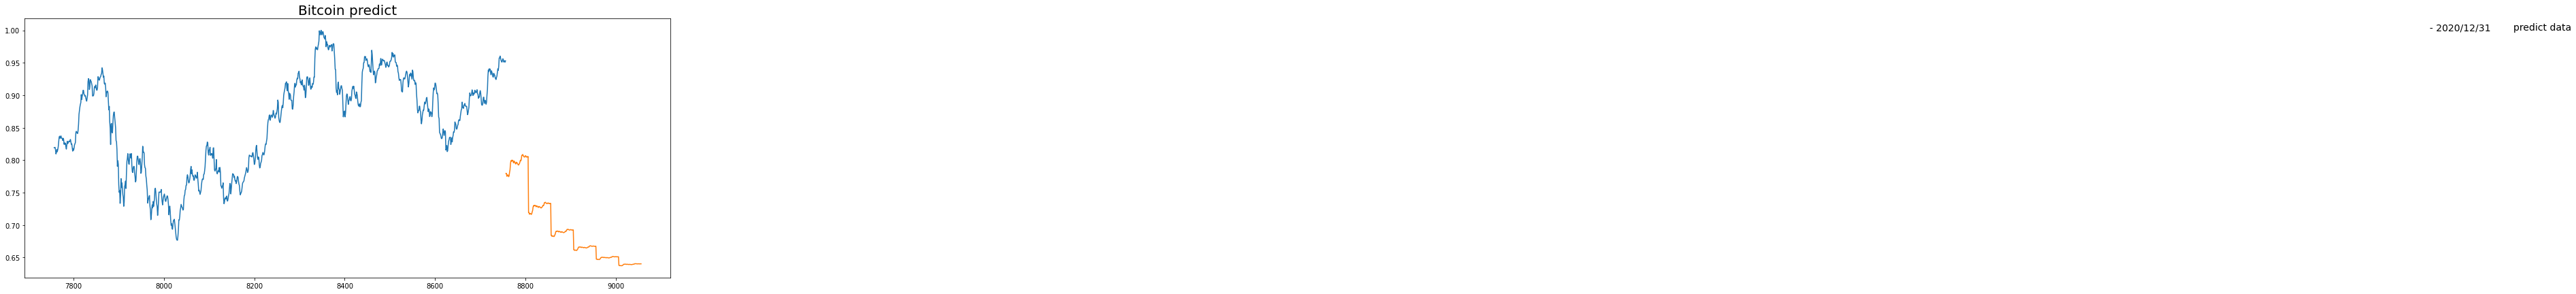

In [15]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','Close']

pred.drop(['z'],axis=1,inplace=True)

data = pd.concat([df.reset_index().drop('Timestamp',axis=1),pred],ignore_index=True)

plt.figure(figsize=(17,7))
plt.plot(data[-1300:-300])
plt.title("Bitcoin predict",fontsize=20)
plt.text(13200,1,"predict data",fontsize=14)
plt.text(13015,1,"- 2020/12/31",fontsize=14)
plt.plot(data[-300:])
plt.show()